In [1]:
import numpy as np
import matplotlib.pyplot as plt

import xarray as xr
import random 
import os 
import pandas as pd 
from global_land_mask import globe

from work import handler
from work import casestudy
from work import storm_tracker

from work.plots.hist import simple_hist

settings_path = 'settings/sam3d.yaml'

hdlr = handler.Handler(settings_path)
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)
st = storm_tracker.StormTracker(cs, overwrite_storms = False, overwrite = False, verbose = True) #overwrite = True is super long, computes growth rate (triangle fit)

Data loaded from /homedata/mcarenso/shear/SAM3d_Tropics/var_id_days_i_t.json
Loading storms...
loading storms from netcdf
Time elapsed for loading storms: 2.59 seconds


In [2]:
duration_min = 6  # or 10
surfmaxkm2_min = 10000  # or other value
region_latmin, region_latmax, region_lonmin, region_lonmax = -15, 30, -180, 180
filename_save = f"wind_init_profile_dataset_storms_dmin{duration_min}_smin{surfmaxkm2_min}_lat{region_latmin}_{region_latmax}_lon{region_lonmin}_{region_lonmax}.nc"
storms_path = os.path.join(st.settings["DIR_DATA_OUT"], cs.name, filename_save)
ds = xr.open_dataset(storms_path)

# filename_save = f"rcond_sigma_storms_dmin{duration_min}_smin{surfmaxkm2_min}_lat{region_latmin}_{region_latmax}_lon{region_lonmin}_{region_lonmax}.nc"
# storms_path = os.path.join(st.settings["DIR_DATA_OUT"], cs.name, filename_save)
# storms = xr.open_dataset(storms_path)
# storms_aligned = storms.reindex(DCS_number=ds['DCS_number'], method=None)  # No interpolation

# all_storms = xr.open_dataset(st.file_storms)
# all_storms_aligned = all_storms.reindex(DCS_number=ds['DCS_number'], method=None)  # No interpolation
# ds = xr.merge([ds, storms_aligned, all_storms_aligned])

def is_ocean(lat1, lon1):
    return not globe.is_land(lat1, lon1)

mask = xr.apply_ufunc(is_ocean,ds["lat_init"],ds["lon_init"], vectorize=True)
ds = ds.where(mask, drop=True)
ds = ds.sel(z=ds.z<=8000)
# ds = ds.drop_isel(DCS_number = [250, 266, 267, 284, 285, 286, 307]) # see data_miniz_viz.ipynb, auto_encoder_v3

In [3]:
filename_save = f"rcond_sigma_storms_dmin{duration_min}_smin{10000}_lat{region_latmin}_{region_latmax}_lon{region_lonmin}_{region_lonmax}.nc"
storms_path = os.path.join(st.settings["DIR_DATA_OUT"], cs.name, filename_save)
ds_rcond = xr.open_dataset(storms_path)
ds_rcond = ds_rcond.reindex(DCS_number=ds['DCS_number'], method=None) ## this is actually filtering

weaks_iDCS = ds_rcond.DCS_number[np.isnan(ds_rcond["INT_rcond_30mmh"].values)]
ds = ds.drop_sel(DCS_number = weaks_iDCS)
ds = xr.merge([ds, ds_rcond])

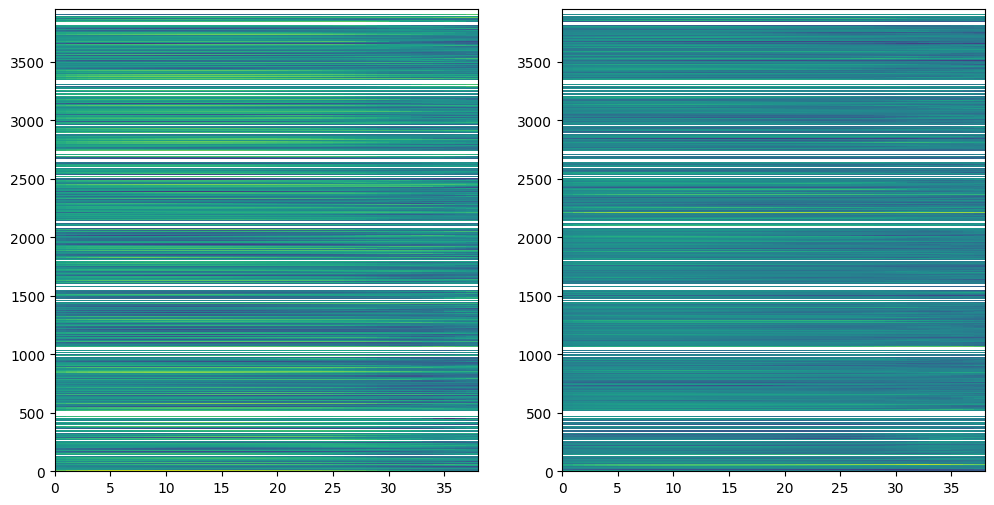

In [4]:
u_init = ds["U_init_profile"]
v_init = ds["V_init_profile"]

fig, axs = plt.subplots(1,2, figsize = (12,6))
axs[0].pcolormesh(u_init)
# print(u_init.shape[0], "DCS before TABS bug")
# print(np.unique(np.where(u_init.values==0)[0]), "fucked TABS init bug")
axs[1].pcolormesh(v_init)
# print(np.unique(np.where(v_init==0)[0]), "fucked TABS max bug")

fucked_DCS = ds.DCS_number.values[np.any(np.isnan(u_init.values), axis = 1)]
ds = ds.drop_sel(DCS_number = fucked_DCS)

In [5]:
DCS_numbers = ds.DCS_number.values
lon_max_list = []
lat_max_list = []
time_max_list = []
for iDCS, DCS_number in enumerate(DCS_numbers):
    start, end, lons, lats, speeds, times, time_smax, i_smax, lons_3d, lats_3d, speeds_3d, times_3d, speed_lon_3d, speed_lat_3d  = st.get_frame_data(ds, DCS_number)
    lon_max_list.append(lons[i_smax+1])
    lat_max_list.append(lats[i_smax+1])
    time_max_list.append(time_smax)

In [6]:
lon_max_list.__len__()
ds["lon_max_instant"] = xr.DataArray(np.array(lon_max_list), dims = ["DCS_number"], coords = {"DCS_number" : ds.DCS_number})
ds["lat_max_instant"] = xr.DataArray(np.array(lat_max_list), dims = ["DCS_number"], coords = {"DCS_number" : ds.DCS_number})
ds["time_max_instant"] = xr.DataArray(np.array(lat_max_list), dims = ["DCS_number"], coords = {"DCS_number" : ds.DCS_number})

# Data Processing


In [7]:
from work.ml_tools.standard_scaler_from_ds import scale_profiles_v4

# Now, use the updated function
X, X_scaled, scaler_profiles = scale_profiles_v4(ds)
num_samples, num_levels, num_features = X.shape

In [8]:
ds

<xarray.Dataset>
Dimensions:              (DCS_number: 3306, z: 38, time: 911)
Coordinates:
  * DCS_number           (DCS_number) int64 153384 153386 ... 297410 299288
  * z                    (z) float32 20.0 61.2 104.9 ... 7.466e+03 7.966e+03
  * time                 (time) int64 817681 817682 817683 ... 818590 818591
Data variables: (12/34)
    U_init_profile       (DCS_number, z) float64 1.614 2.084 ... -2.111 -1.177
    V_init_profile       (DCS_number, z) float64 5.26 6.561 ... 1.607 1.457
    lon_init             (DCS_number) float64 148.9 147.2 ... -159.3 -161.4
    lat_init             (DCS_number) float64 11.06 12.61 12.8 ... 24.9 24.29
    time_init            (DCS_number) float64 1.008e+03 1.008e+03 ... 1.884e+03
    INT_UTC_timeInit     (DCS_number) float64 1.472e+09 1.472e+09 ... 1.473e+09
    ...                   ...
    INT_sigma_1mmh       (DCS_number) float64 0.2953 0.2095 ... 0.3622 0.3787
    INT_sigma_10mmh      (DCS_number) float64 0.04556 0.03832 ... 0.07533 0.115
    INT_sigma_30mmh      (DCS_number) float64 0.0005237 0.002651 ... 0.009137
    lon_max_instant      (DCS_number) float64 149.2 147.3 ... -159.3 -161.4
    lat_max_instant      (DCS_number) float64 11.1 13.17 13.12 ... 25.77 24.56
    time_max_instant     (DCS_number) float64 11.1 13.17 13.12 ... 25.77 24.56

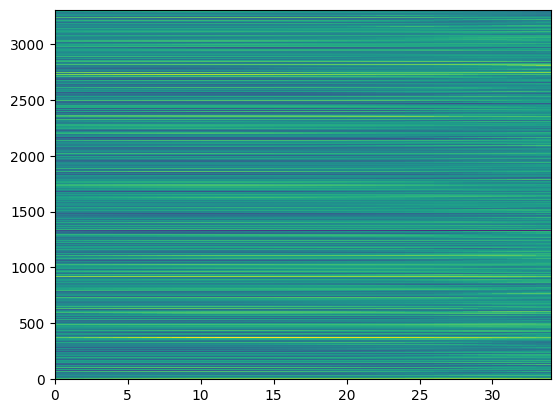

In [9]:
plt.pcolormesh(X_scaled[:,:,0])

## Scale for each features*levels individually (works better)

In [10]:
import joblib
path_scaler_save = os.path.join(st.settings["DIR_DATA_OUT"], cs.name, 'scaler_profiles.joblib')
joblib.dump(scaler_profiles, path_scaler_save)

['/homedata/mcarenso/shear/SAM3d_Tropics/scaler_profiles.joblib']

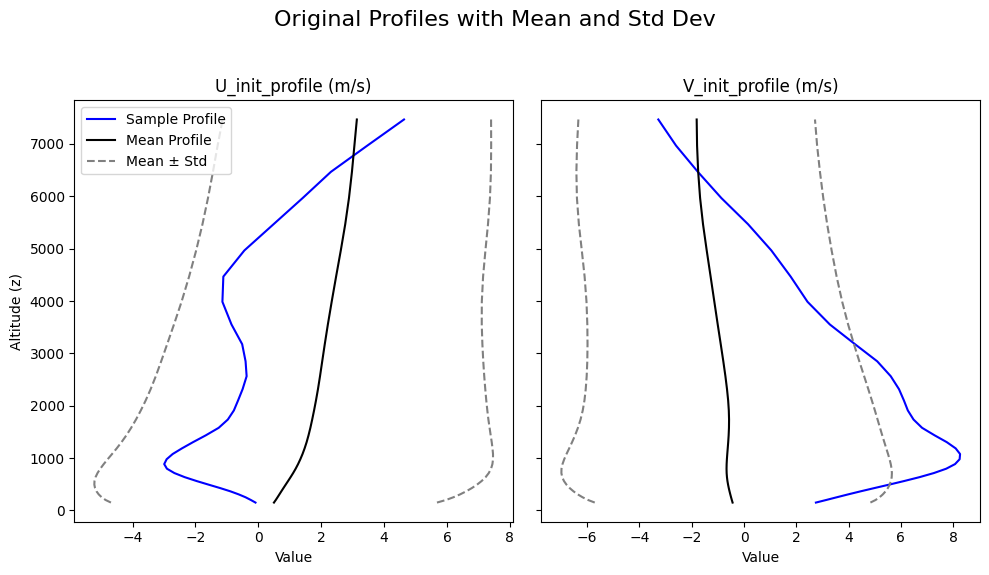

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import circmean, circstd


variables = [
    "U_init_profile", "V_init_profile"
    # 'TABS_init_profile', 'QV_init_profile', 'tangeant_wind_init', 'normal_wind_init', 'shear_tangeant_init', 'shear_normal_init', #'shear_magnitude_init', #'shear_magnitude_init_bis',
    # 'TABS_max_instant_profile', 'QV_max_instant_profile', 'tangeant_wind_max_instant', 'normal_wind_max_instant', 'shear_tangeant_max_instant', 'shear_normal_max_instant', #'shear_magnitude_max', #'shear_magnitude_max_bis'
]
units = [
    'm/s', 'm/s',
    # 'K', 'g/kg', 'm/s', 'm/s', '(m/s)/km', '(m/s)/km',
    # 'K', 'g/kg', 'm/s', 'm/s', '(m/s)/km', '(m/s)/km'
]
num_samples, num_levels, num_features = X.shape

# Initialize arrays for mean and std dev profiles
mean_profiles = np.zeros((num_levels, num_features))
std_profiles = np.zeros((num_levels, num_features))

# Compute mean and std dev for each feature at each level over all samples
for i, var in enumerate(variables):
    if var in ['shear_direction_init', 'shear_direction_max']:
        # Use circular statistics for angular data
        mean_profiles[:, i] = np.degrees(circmean(np.radians(X[:, :, i]), high=np.pi, low=-np.pi, axis=0))
        std_profiles[:, i] = np.degrees(circstd(np.radians(X[:, :, i]), high=np.pi, low=-np.pi, axis=0))
    else:
        mean_profiles[:, i] = np.mean(X[:, :, i], axis=0)
        std_profiles[:, i] = np.std(X[:, :, i], axis=0)

# Split data into training and test sets (if needed)
indices = np.arange(num_samples)
X_train, X_test, idx_train, idx_test = train_test_split(
    X, indices, test_size=0.2, random_state=42
)

# Select a random sample from the test set
sample_index = np.random.choice(range(X_test.shape[0]))
ds_index = idx_test[sample_index]  # Index in the original dataset

# Extract the original data for the selected sample
original_sample = X_test[sample_index]  # Shape: (num_levels, num_features)

z_levels = ds['z'].values[3:-1]  # Vertical levels (assuming shape (num_levels,))

# Prepare to plot
n_cols = len(variables)
fig, axes = plt.subplots(1, n_cols, figsize=(10, 6), sharey=True)
fig.suptitle('Original Profiles with Mean and Std Dev', fontsize=16)

for i, var, unit in zip(np.arange(len(variables)), variables, units):
    ax = axes[i % n_cols]

    # Extract the profiles for each variable
    sample_profile = original_sample[:, i]
    mean_profile = mean_profiles[:, i]
    std_profile = std_profiles[:, i]

    # Handle wind shear direction (convert to degrees and wrap angles)
    if var in ['shear_direction_init', 'shear_direction_max']:
        sample_profile = np.degrees(np.arctan2(np.sin(np.radians(sample_profile)), np.cos(np.radians(sample_profile))))
        upper_std = (mean_profile + std_profile + 180) % 360 - 180
        lower_std = (mean_profile - std_profile + 180) % 360 - 180
    else:
        upper_std = mean_profile + std_profile
        lower_std = mean_profile - std_profile

    # Plot sample profile
    ax.plot(sample_profile, z_levels, label='Sample Profile', color='blue')

    # Plot mean profile
    ax.plot(mean_profile, z_levels, color='black', linestyle='-', label='Mean Profile')

    # Plot mean ± std dev profiles
    ax.plot(upper_std, z_levels, color='grey', linestyle='--', label='Mean ± Std' if i == 0 else "")
    ax.plot(lower_std, z_levels, color='grey', linestyle='--')

    ax.set_title(var+" ("+unit+")")
    ax.set_xlabel('Value')

    if i % n_cols == 0:
        ax.set_ylabel('Altitude (z)')
    ax.invert_yaxis()  # Invert y-axis if altitude increases with decreasing index

    if i == 0:
        ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

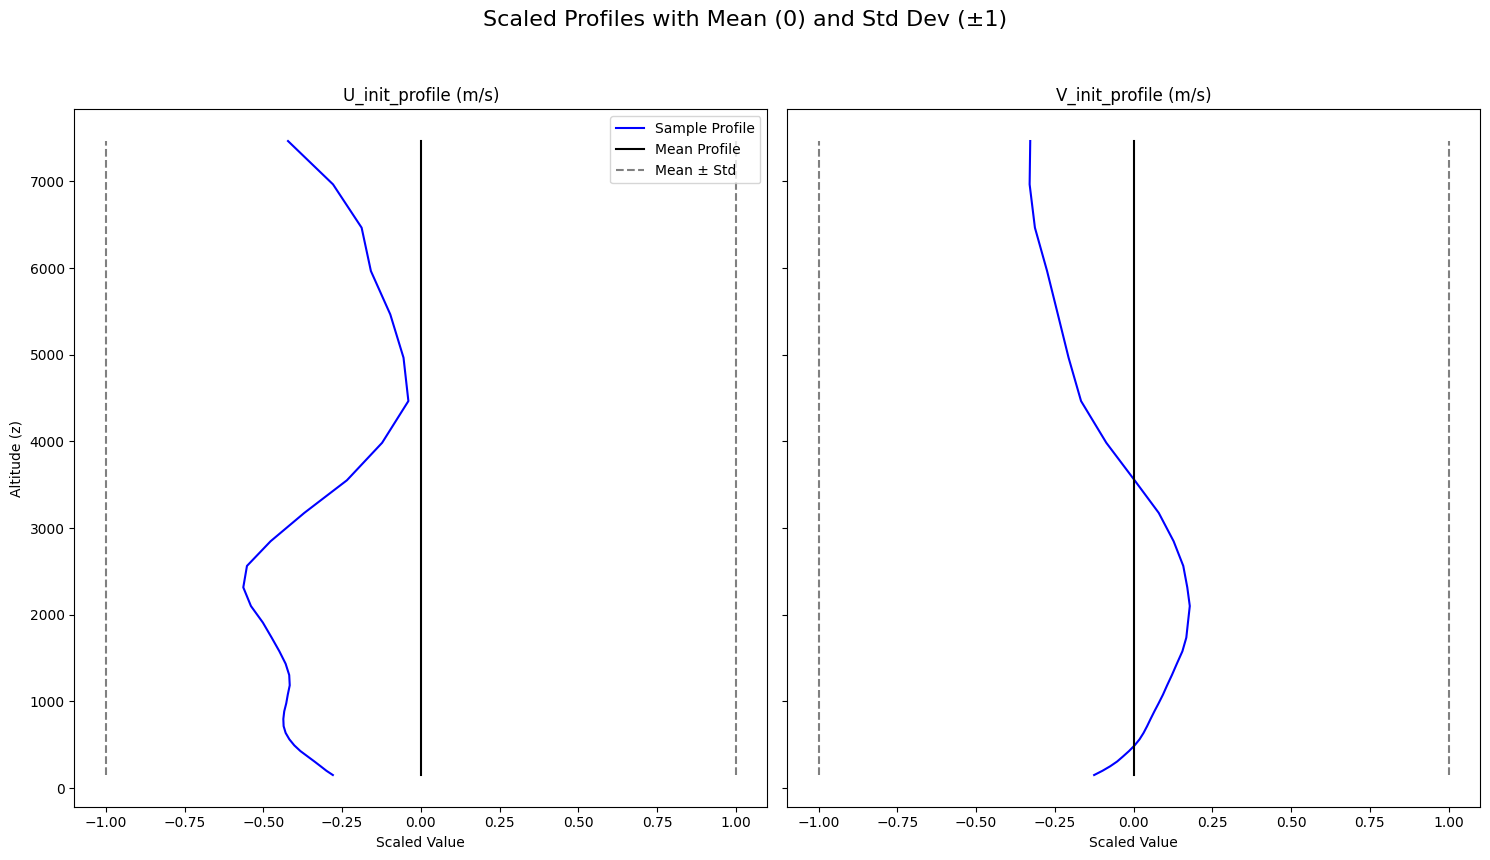

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Assume X and ds are already defined
variables = [
    "U_init_profile", "V_init_profile"
    # 'TABS_init_profile', 'QV_init_profile', 'tangeant_wind_init', 'normal_wind_init', 'shear_tangeant_init', 'shear_normal_init'
]
units = [
    'm/s', 'm/s'
    # 'K', 'g/kg', 'm/s', 'm/s', '(m/s)/km', '(m/s)/km'
]
num_samples, num_levels, num_features = X.shape

# Initialize arrays for mean and std dev profiles
mean_profiles = np.zeros((num_levels, num_features))
std_profiles = np.zeros((num_levels, num_features))

# Compute mean and std dev for each feature at each level over all samples
for i, var in enumerate(variables):
    mean_profiles[:, i] = np.mean(X[:, :, i], axis=0)
    std_profiles[:, i] = np.std(X[:, :, i], axis=0)

# Avoid division by zero in scaling
std_profiles_no_zero = std_profiles.copy()
std_profiles_no_zero[std_profiles_no_zero == 0] = 1

# Scale the data
X_scaled = (X - mean_profiles[None, :, :]) / std_profiles_no_zero[None, :, :]

# Compute mean and std of scaled data (should be zero and one)
mean_profiles_scaled = np.mean(X_scaled, axis=0)
std_profiles_scaled = np.std(X_scaled, axis=0)

# Split data into training and test sets (if needed)
indices = np.arange(num_samples)
X_train_scaled, X_test_scaled, idx_train, idx_test = train_test_split(
    X_scaled, indices, test_size=0.2, random_state=42
)

# Select a random sample from the test set
sample_index = np.random.choice(range(X_test_scaled.shape[0]))
ds_index = idx_test[sample_index]  # Index in the original dataset

# Extract the scaled data for the selected sample
original_sample = X_test_scaled[sample_index]  # Shape: (num_levels, num_features)

z_levels = ds['z'].values[3:-1]  # Vertical levels (assuming shape (num_levels,))

# Prepare to plot
n_cols = len(variables)
fig, axes = plt.subplots(1, n_cols, figsize=(15, 9), sharey=True)
fig.suptitle('Scaled Profiles with Mean (0) and Std Dev (±1)', fontsize=16)

for i, (var, unit) in enumerate(zip(variables, units)):
    ax = axes[i % n_cols]

    # Extract the profiles for each variable
    sample_profile = original_sample[:, i]
    mean_profile = mean_profiles_scaled[:, i]  # Should be close to zero
    std_profile = std_profiles_scaled[:, i]    # Should be close to one

    # For plotting mean ± std dev
    upper_std = mean_profile + std_profile
    lower_std = mean_profile - std_profile

    # Plot sample profile
    ax.plot(sample_profile, z_levels, label='Sample Profile', color='blue')

    # Plot mean profile (should be zero)
    ax.plot(mean_profile, z_levels, color='black', linestyle='-', label='Mean Profile')

    # Plot mean ± std dev profiles
    ax.plot(upper_std, z_levels, color='grey', linestyle='--', label='Mean ± Std' if i == 0 else "")
    ax.plot(lower_std, z_levels, color='grey', linestyle='--')

    ax.set_title(f"{var} ({unit})")
    ax.set_xlabel('Scaled Value')

    if i % n_cols == 0:
        ax.set_ylabel('Altitude (z)')
    ax.invert_yaxis()  # Invert y-axis if altitude increases with decreasing index

    if i == 0:
        ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Model Building #

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

2024-12-17 12:40:14.211166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-17 12:40:14.227714: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-17 12:40:14.232615: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 12:40:14.245350: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-17 12:40:15.738857: W tensorflow/compiler/tf2

## CNNs Conv1D

In [30]:
latent_space_size = 32
model_name = "ae_conv1D_v0"+f"_latent_{latent_space_size}"

# Input layer
input_shape = (num_levels, num_features)  # Replace num_channels with the number of input channels
inputs = layers.Input(shape=input_shape)

# Encoder
encoded = layers.Conv1D(512, kernel_size=3, activation='relu', padding='same')(inputs)
# encoded = layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(encoded)
# encoded = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(encoded)
attention_output = layers.Attention()([encoded, encoded])
flattened = layers.Flatten()(attention_output)
encoded = layers.Dense(64, activation='relu')(flattened)
# encoded = layers.Dense(32, activation='relu')(flattened)
bottleneck = layers.Dense(latent_space_size, activation='relu')(encoded)

# Decoder
# decoded = layers.Dense(32, activation='relu')(bottleneck)
decoded = layers.Dense(64, activation='relu')(bottleneck)
decoded = layers.Dense(52 * 32, activation='relu')(decoded)
decoded = layers.Reshape((52, 32))(decoded)
# decoded = layers.Conv1DTranspose(32, kernel_size=3, activation='relu', padding='same')(decoded)
# decoded = layers.Conv1DTranspose(128, kernel_size=3, activation='relu', padding='same')(decoded)
decoded = layers.Conv1DTranspose(512, kernel_size=3, activation='relu', padding='same')(decoded)
reconstructed_output = layers.Conv1DTranspose(input_shape[-1], kernel_size=3, activation='linear', padding='same')(decoded)

# Autoencoder model
autoencoder = models.Model(inputs, reconstructed_output, name = model_name)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "ae_conv1D_v0_latent_32"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 46, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 46, 512)   │      9,728 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 46, 512)   │          0 │ conv1d_1[0][0],   │
│ (Attention)         │                   │            │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 23552)     │          0 │ attention_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64)        │  1,507,392 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 32)        │      2,080 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 64)        │      2,112 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 1664)      │    108,160 │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 52, 32)    │          0 │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_transpose_2  │ (None, 52, 512)   │     49,664 │ reshape_3[0][0]   │
│ (Conv1DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_transpose_3  │ (None, 52, 6)     │      9,222 │ conv1d_transpose… │
│ (Conv1DTranspose)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,688,358 (6.44 MB)

 Trainable params: 1,688,358 (6.44 MB)

 Non-trainable params: 0 (0.00 B)

## LSTM 

In [31]:
latent_space_size = 64
model_name = "ae_LSTM_v0"+f"_latent_{latent_space_size}"

# Input layer
input_shape = (num_levels, num_features)
inputs = layers.Input(shape=input_shape)

# Encoder
encoded = layers.LSTM(64, return_sequences=True)(inputs)
encoded = layers.LSTM(32)(encoded)
bottleneck = layers.Dense(latent_space_size, activation='relu')(encoded)

# Decoder
decoded = layers.RepeatVector(num_levels)(bottleneck)
decoded = layers.LSTM(32, return_sequences=True)(decoded)
decoded = layers.LSTM(64, return_sequences=True)(decoded)
reconstructed_output = layers.TimeDistributed(layers.Dense(num_features, activation='linear'))(decoded)

# Autoencoder model
autoencoder = models.Model(inputs, reconstructed_output, name = model_name)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "ae_LSTM_v0_latent_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 46, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 46, 64)         │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 46, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 46, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 46, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 46, 6)          │           390 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,342 (274.77 KB)

 Trainable params: 70,342 (274.77 KB)

 Non-trainable params: 0 (0.00 B)

## Fully Connected

In [16]:
latent_space_size = 6
model_name = 'ae_fully_connected_v4'+f"_latent_{latent_space_size}"

# Input layer
input_shape = (num_levels, num_features)
inputs = layers.Input(shape=input_shape)

# Flatten the input
flattened_inputs = layers.Flatten()(inputs)

# Encoder
# encoded = layers.Dense(512, activation='relu')(flattened_inputs)
encoded = layers.Dense(256, activation='relu')(flattened_inputs)
encoded = layers.Dense(128, activation='relu')(encoded)
# encoded = layers.Dense(64, activation='relu')(encoded)
bottleneck = layers.Dense(latent_space_size, activation='relu')(encoded)

# Decoder
# decoded = layers.Dense(64, activation='relu')(bottleneck)
decoded = layers.Dense(128, activation='relu')(bottleneck) #decpded
decoded = layers.Dense(256, activation='relu')(decoded)
# decoded = layers.Dense(512, activation='relu')(decoded)
decoded = layers.Dense(num_levels * num_features, activation='linear')(decoded)

# Reshape the output
reconstructed_output = layers.Reshape((num_levels, num_features))(decoded)

def custom_loss(y_true, y_pred):
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    smoothness_loss = tf.reduce_mean(tf.square(y_pred[:, 1:, :] - y_pred[:, :-1, :]))
    return mse_loss + smoothness_weight * smoothness_loss

# Autoencoder model
autoencoder = models.Model(inputs, reconstructed_output, name=model_name)
smoothness_weight = 5  # Adjust this hyperparameter
autoencoder.compile(optimizer='adam', loss='mse') #loss=custom_loss for forced smoothness

autoencoder.summary()

Model: "ae_fully_connected_v4_latent_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 34, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 68)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 68)             │        17,476 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 34, 2)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,730 (401.29 KB)

 Trainable params: 102,730 (401.29 KB)

 Non-trainable params: 0 (0.00 B)

### Model Training

In [17]:
from sklearn.model_selection import train_test_split
 
print("Training buddy : ", model_name)
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)


history = autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test, X_test)
)

Training buddy :  ae_fully_connected_v4_latent_6
Epoch 1/100


83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5082 - val_loss: 0.0779
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0683 - val_loss: 0.0459
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0461 - val_loss: 0.0343
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0290 - val_loss: 0.0227
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0217 - val_loss: 0.0188
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0201 - val_loss: 0.0189
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0191 - val_loss: 0.0218
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0200 - val_loss: 0.0180
Epoch 9/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0197 - val_loss: 0.0257
Epoch 10/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0220 - val_loss: 0.0189
Epoch 11/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0196 - val_loss: 0.0189
Epoch 12/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0180 - val_lo

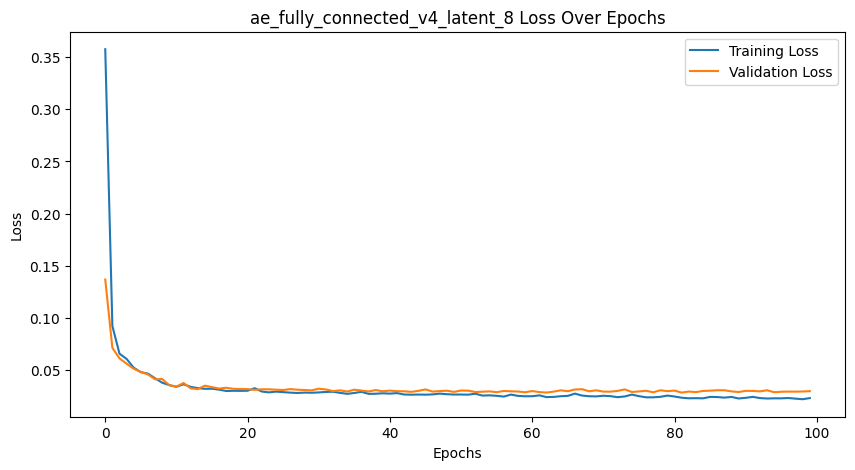

In [83]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{model_name} Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
# Encoder model
encoder = keras.Model(inputs=inputs, outputs=bottleneck)
encoded_data = encoder.predict(X_scaled)

ae_name = f'{model_name}_v0.keras'
save_path_ae = os.path.join(st.settings["DIR_DATA_OUT"], cs.name, ae_name)
autoencoder.save(save_path_ae)
print("saved : ", ae_name)

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
saved :  ae_fully_connected_v4_latent_6_v0.keras


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


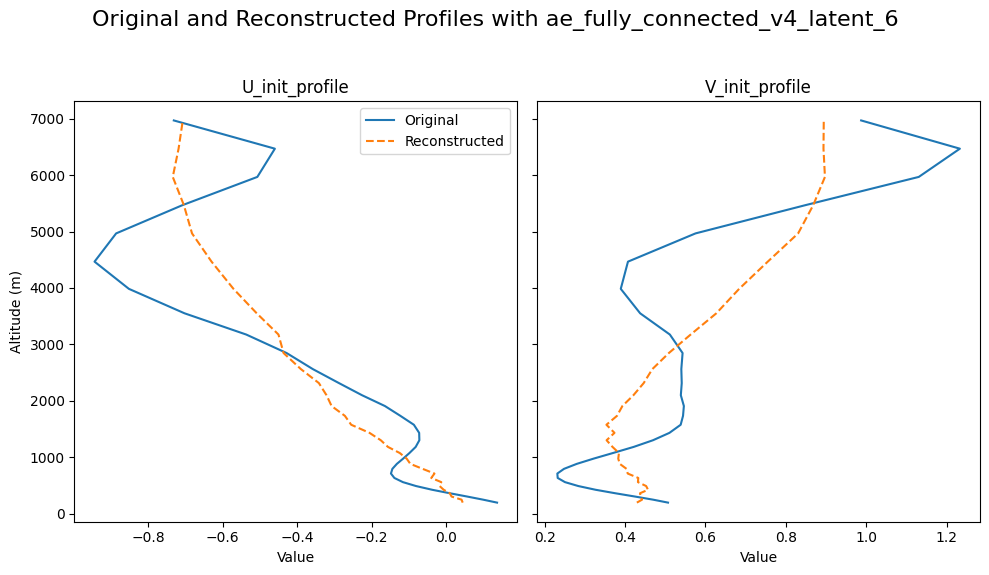

In [125]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Assuming 'ds', 'X_scaled', and 'autoencoder' are already defined

# # Variable names in the order they were concatenated
# variables = [
#     'TABS_init_profile', 'QV_init_profile', 'U_init_profile', 'V_init_profile',
#     'TABS_max_instant_profile', 'QV_max_instant_profile', 'U_max_instant_profile', 'V_max_instant_profile'
# ]

variables = [
    "U_init_profile", "V_init_profile"
    # 'TABS_init_profile', 'QV_init_profile', 'tangeant_wind_init', 'normal_wind_init', 'shear_tangeant_init', 'shear_normal_init', #'shear_magnitude_init', #'shear_magnitude_init_bis',
    # 'TABS_max_instant_profile', 'QV_max_instant_profile', 'tangeant_wind_max_instant', 'normal_wind_max_instant', 'shear_tangeant_max_instant', 'shear_normal_max_instant', #'shear_magnitude_max', #'shear_magnitude_max_bis'
]

indices = np.arange(num_samples)

# Perform train_test_split with indices to keep track
X_train, X_test, idx_train, idx_test = train_test_split(
    X_scaled, indices, test_size=0.2, random_state=42
)

# Reconstruct inputs using the trained autoencoder
reconstructed_data = autoencoder.predict(X_test)

sample_index = np.random.choice(range(X_test.shape[0]))
ds_index = idx_test[sample_index]  # Index in the original dataset

# Extract the original and reconstructed data for the selected samplerray([   20.   ,    61.2  ,   104.872,
original_sample = X_test[sample_index]           # Shape: (num_levels, num_features)
reconstructed_sample = reconstructed_data[sample_index]  # Shape: (num_levels, num_features)

z_levels = ds['z'].values[4:-2]  # Vertical levels

# Extract the profiles for each variable
original_profiles = {}
reconstructed_profiles = {}

for i, var in enumerate(variables):
    original_profiles[var] = original_sample[:, i]        # Shape: (num_levels,)
    reconstructed_profiles[var] = reconstructed_sample[:, i]  # Shape: (num_levels,)

# Plot profiles in subplots
n_cols = 2
fig, axes = plt.subplots(1, n_cols, figsize=(10, 6), sharey=True)
fig.suptitle('Original and Reconstructed Profiles with '+f"{model_name}", fontsize=16)

for i, var in enumerate(variables):
    ax = axes[i % n_cols]
    # Plot original and reconstructed profiles
    ax.plot(original_profiles[var], z_levels, label='Original')
    ax.plot(reconstructed_profiles[var], z_levels, label='Reconstructed', linestyle='--')
    ax.set_title(var)
    ax.set_xlabel('Value')
    if i % 4 == 0:
        ax.set_ylabel('Altitude (m)')
    ax.invert_yaxis()  # Invert y-axis if your altitude increases with decreasing index
    if i == 0:
        ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [126]:
import numpy as np
import matplotlib.pyplot as plt

n_worst = 5

# Reconstruct inputs using the trained autoencoder
reconstructed_data_scaled = autoencoder.predict(X_scaled)  # Shape: (num_samples, num_levels, num_features)

# Reshape the scaled data for inverse transformation
num_samples, num_levels, num_features = X_scaled.shape
X_scaled_reshaped = X_scaled.reshape(-1, num_features)
reconstructed_scaled_reshaped = reconstructed_data_scaled.reshape(-1, num_features)

# Inverse transform to get original units
X_unscaled_reshaped = scaler_profiles.inverse_transform(X_scaled_reshaped)
reconstructed_unscaled_reshaped = scaler_profiles.inverse_transform(reconstructed_scaled_reshaped)

# Reshape back to original shape
X_unscaled = X_unscaled_reshaped.reshape(num_samples, num_levels, num_features)
reconstructed_unscaled = reconstructed_unscaled_reshaped.reshape(num_samples, num_levels, num_features)

# Compute the MSE per sample over all variables and levels (on unscaled data)
mse_per_sample = np.mean((X_unscaled - reconstructed_unscaled)**2, axis=(1,2))  # Shape: (num_samples,)

# Find indices of the samples with the worst (highest) MSE
worst_indices = np.argsort(mse_per_sample)[-n_worst:]  # Indices of top 5 MSE samples
# worst_indices = np.argsort(mse_per_sample)[:n_worst]  # Indices of top 5 MSE samples

print("Indices of the 5 worst MSE samples overall:", worst_indices)

# Compute MSE per variable (profile) per sample (on unscaled data)
worst_indices_per_variable = {}

for i, var in enumerate(variables):
    mse_var = np.mean((X_unscaled[:,:,i] - reconstructed_unscaled[:,:,i])**2, axis=1)  # Shape: (num_samples,)
    worst_indices_var = np.argsort(mse_var)[-n_worst:]
    worst_indices_per_variable[var] = worst_indices_var
    print(f"Indices of the 5 worst MSE samples for variable '{var}':", worst_indices_var)

# Function to plot the profiles
def plot_sample(sample_index, X_data_unscaled, reconstructed_data_unscaled, variables, z_levels, ds_index=None, model_name="Model"):
    # Extract the original and reconstructed data for the selected sample
    original_sample = X_data_unscaled[sample_index]           # Shape: (num_levels, num_features)
    reconstructed_sample = reconstructed_data_unscaled[sample_index]  # Shape: (num_levels, num_features)
    
    # Extract the profiles for each variable
    original_profiles = {}
    reconstructed_profiles = {}
    
    for i, var in enumerate(variables):
        original_profiles[var] = original_sample[:, i]        # Shape: (num_levels,)
        reconstructed_profiles[var] = reconstructed_sample[:, i]  # Shape: (num_levels,)
    
    # Plot profiles in subplots
    n_cols = 2
    n_rows = int(np.ceil(len(variables)/n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 6), sharey=True)
    fig.suptitle('Original and Reconstructed Profiles with '+f"{model_name}", fontsize=16)
    
    axes = axes.flatten()
    for i, var in enumerate(variables):
        ax = axes[i]
        # Plot original and reconstructed profiles
        ax.plot(original_profiles[var], z_levels, label='Original')
        ax.plot(reconstructed_profiles[var], z_levels, label='Reconstructed', linestyle='--')
        ax.set_title(var)
        ax.set_xlabel('Value')
        if i % n_cols == 0:
            ax.set_ylabel('Altitude (m)')
        ax.invert_yaxis()  # Invert y-axis if your altitude increases with decreasing index
        if i == 0:
            ax.legend()
    
    # Hide any unused subplots
    for j in range(len(variables), n_rows * n_cols):
        fig.delaxes(axes[j])
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Plot the profiles for the 5 worst samples overall
for idx in worst_indices:
    # print(f"\nPlotting sample with index {idx} (Overall Worst MSE)")
    # plot_sample(idx, X_unscaled, reconstructed_unscaled, variables, z_levels, ds_index=idx, model_name="Autoencoder")
    continue

# Optionally, plot the worst samples per variable
for var in variables:
    # print(f"\nPlotting worst samples for variable '{var}'")
    for idx in worst_indices_per_variable[var]:
        # print(f"Sample index {idx} (Worst MSE for {var})")
        # plot_sample(idx, X_unscaled, reconstructed_unscaled, variables, z_levels, ds_index=idx, model_name="Autoencoder")
        continue

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
Indices of the 5 worst MSE samples overall: [ 324 1119 3256 2531 2687]
Indices of the 5 worst MSE samples for variable 'U_init_profile': [ 520 3256 1119 2531 2687]
Indices of the 5 worst MSE samples for variable 'V_init_profile': [ 368 2315  324 2687 2531]


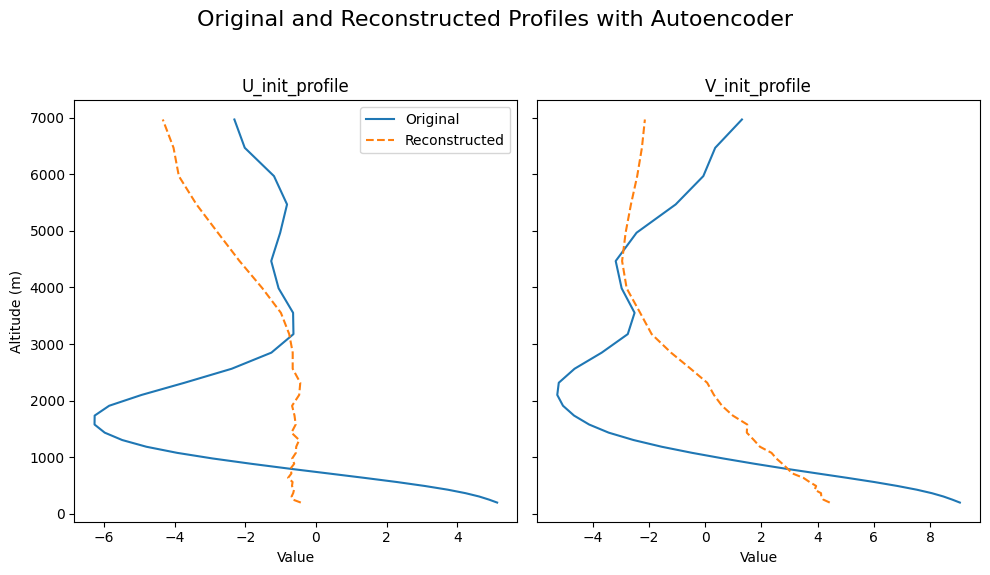

In [131]:
idx = 2687
plot_sample(idx, X_unscaled, reconstructed_unscaled, variables, z_levels, ds_index=idx, model_name="Autoencoder")